In [ ]:
# importing Libraries 
import pandas as pd
import numpy as np
import os
import re
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
import albumentations
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [ ]:
# reading the train file 
df = pd.read_csv("/content/drive/MyDrive/Wheat_Detection/train.csv")

In [ ]:
# Regex for bounding box in the dataframe 
def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

In [ ]:
# adding four individual column for the expansion of bounding boxes+
df['x'] = -1
df['y'] = -1
df['w'] = -1
df['h'] = -1

df[['x', 'y', 'w', 'h']] = np.stack(df['bbox'].apply(lambda x: expand_bbox(x)))

# making all of this as float 
df['x'] = df['x'].astype(float)
df['y'] = df['y'].astype(float)
df['w'] = df['w'].astype(float)
df['h'] = df['h'].astype(float)

#compute x1 and y1 for pascal format [x, y, x1 = x+w, y1 = y+h]
# dropping the bbox from the dataframe 
df.drop(columns=['bbox'], inplace=True)
df['x1'] = df['x'] + df['w']
df['y1'] = df['y'] + df['h']
df['area'] = df['w'] * df['h']

In [ ]:
# np.stack(df['bbox'].apply(lambda x: expand_box(x)))
# df[['x', 'y', 'w','h']]
df.head()

,image_id,width,height,source,x,y,w,h,x1,y1,area
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0,890.0,258.0,2016.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0,356.0,606.0,7540.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0,451.0,664.0,11840.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0,943.0,202.0,11663.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0,150.0,261.0,14508.0


In [ ]:
# Splitting the Dataset 
# splitting based on image_id
# 80% sample images for training
# 20% sample images for testing
# make new column(folds) where 0 = validation, 1 = train

val_len = int(len(df['image_id'].unique()) * 0.1)

train_set = df['image_id'].unique()[val_len:]
val_set = df['image_id'].unique()[:val_len]

df['folds'] = -1 

df.loc[df.image_id.isin(train_set), 'folds'] = 1
df.loc[df.image_id.isin(val_set), 'folds'] = 0

df["image_id"] = df["image_id"] + ".jpg"

df.head()

,image_id,width,height,source,x,y,w,h,x1,y1,area,folds
0,b6ab77fd7.jpg,1024,1024,usask_1,834.0,222.0,56.0,36.0,890.0,258.0,2016.0,0
1,b6ab77fd7.jpg,1024,1024,usask_1,226.0,548.0,130.0,58.0,356.0,606.0,7540.0,0
2,b6ab77fd7.jpg,1024,1024,usask_1,377.0,504.0,74.0,160.0,451.0,664.0,11840.0,0
3,b6ab77fd7.jpg,1024,1024,usask_1,834.0,95.0,109.0,107.0,943.0,202.0,11663.0,0
4,b6ab77fd7.jpg,1024,1024,usask_1,26.0,144.0,124.0,117.0,150.0,261.0,14508.0,0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create Pytorch dataset class
class WheatDataset(Dataset):
    def __init__(self, dataframe, is_train, transforms = None):
        super(WheatDataset, self).__init__()

        self.df = dataframe
        
        self.transforms = transforms
        
        if is_train:
            self.df = self.df[self.df.folds == 1].reset_index(drop=True)
            self.img_ids = self.df['image_id'].unique()
        else:
            self.df = self.df[self.df.folds == 0].reset_index(drop=True)
            self.img_ids = self.df['image_id'].unique()
        
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, item):
        
        img_idx = self.img_ids[item]
        
        images = cv2.imread(os.path.join("/content/drive/MyDrive/Wheat_Detection/train", img_idx), cv2.IMREAD_COLOR)
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        data = self.df[self.df['image_id'] == img_idx]
        bbox = data[['x','y','x1','y1']].values
        area = data['area'].values
        
        labels = np.ones((bbox.shape[0],))
        is_crowd = np.zeros((bbox.shape[0],))
        taget = {'image':images , 'bboxes': bbox, 'labels': labels,}
        
        if self.transforms:
            transforms = self.transforms(**taget)
            images, bboxs, labels = transforms['image'], transforms['bboxes'], transforms['labels']
            
        images = np.transpose(images, (2, 0, 1)).astype(np.float32)
        
        dict_target = {"boxes": torch.tensor(bboxs, dtype = torch.long), 
                    "area" : torch.tensor(area, dtype = torch.long),
                    "labels": torch.tensor(labels, dtype = torch.long),
                    "iscrowd": torch.tensor(is_crowd, dtype = torch.long),
                   }
        
        return torch.tensor(images, dtype = torch.float), dict_target

In [ ]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_MEAN = (0.5, 0.5, 0.5)
IMG_STD = (0.5, 0.5, 0.5)
BACTH_SIZE = 4

In [ ]:
# import numpy as np
# import pandas as pd
# import cv2 as cv 
# from google.colab.patches import cv2_imshow # for image display
# from skimage import io
# from PIL import Image 
# import matplotlib.pylab as plt
# images = io.imread("/content/drive/MyDrive/Wheat Detection/train/00333207f.jpg", 0)
# image_2 = cv.cvtColor(images, cv.COLOR_BGR2RGB)

# # cv2_imshow(image_2)

# h, w, c = image_2.shape
# print('width:  ', w)
# print('height: ', h)
# print('channel:', c)

# # mean, std = cv2_imshow.meanStdDev(image_2)
# mean = np.mean(image_2)
# print(mean)
# std = np.std(image_2)
# print(std)

# image_2.shape[2]

In [ ]:
# Augmentations 
# Flip = random vertical, random horizontal or random both vertical and horizontal
# resize to 512x512
# Normalize

train_aug = albumentations.Compose([
            albumentations.Flip(),
            albumentations.Resize(IMG_HEIGHT, IMG_HEIGHT, always_apply = True),            
            albumentations.Normalize(IMG_MEAN, IMG_STD, always_apply = True)
            ], bbox_params = albumentations.BboxParams(format = 'pascal_voc', 
                                                       label_fields=['labels']))

train_data = WheatDataset(dataframe= df , is_train = True, transforms = train_aug)

print("Number of images in training dataset", len(train_data))

Number of images in training dataset 3036


In [ ]:
# DataLoader 
def collate_fn(batch):
    return list(zip(*batch))

trainloader = DataLoader(train_data,
                           batch_size=BACTH_SIZE,
                           shuffle=False,
                           num_workers=0,
                           collate_fn = collate_fn)

In [ ]:
# !pip install augmentation-lib

In [ ]:
idx = 18
data = train_data[idx]
img, bbx = data
bbx = bbx['boxes']
img = img / 2 + 0.5    # unnormalize
npimg = img.numpy()
bbx = bbx.numpy()
npimg = np.transpose(npimg,(1, 2, 0))

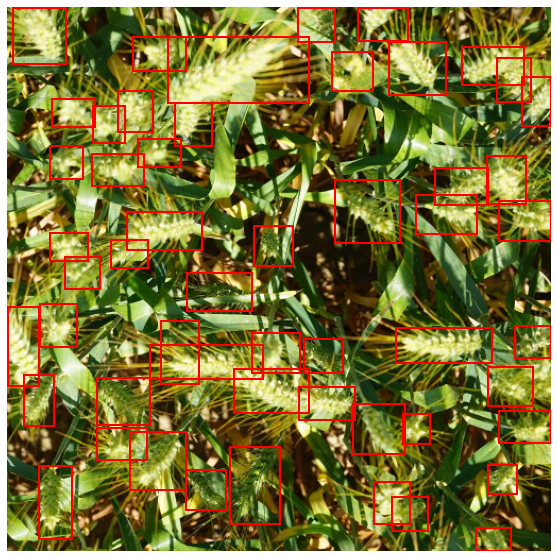

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

for b in bbx:
        ax.add_patch(
            patches.Rectangle(
            (b[0], b[1]),
            b[2]-b[0],
            b[3]-b[1],
            linewidth=2,
            fill=False,
            color='red'))
    
ax.set_axis_off()
ax.imshow(npimg)

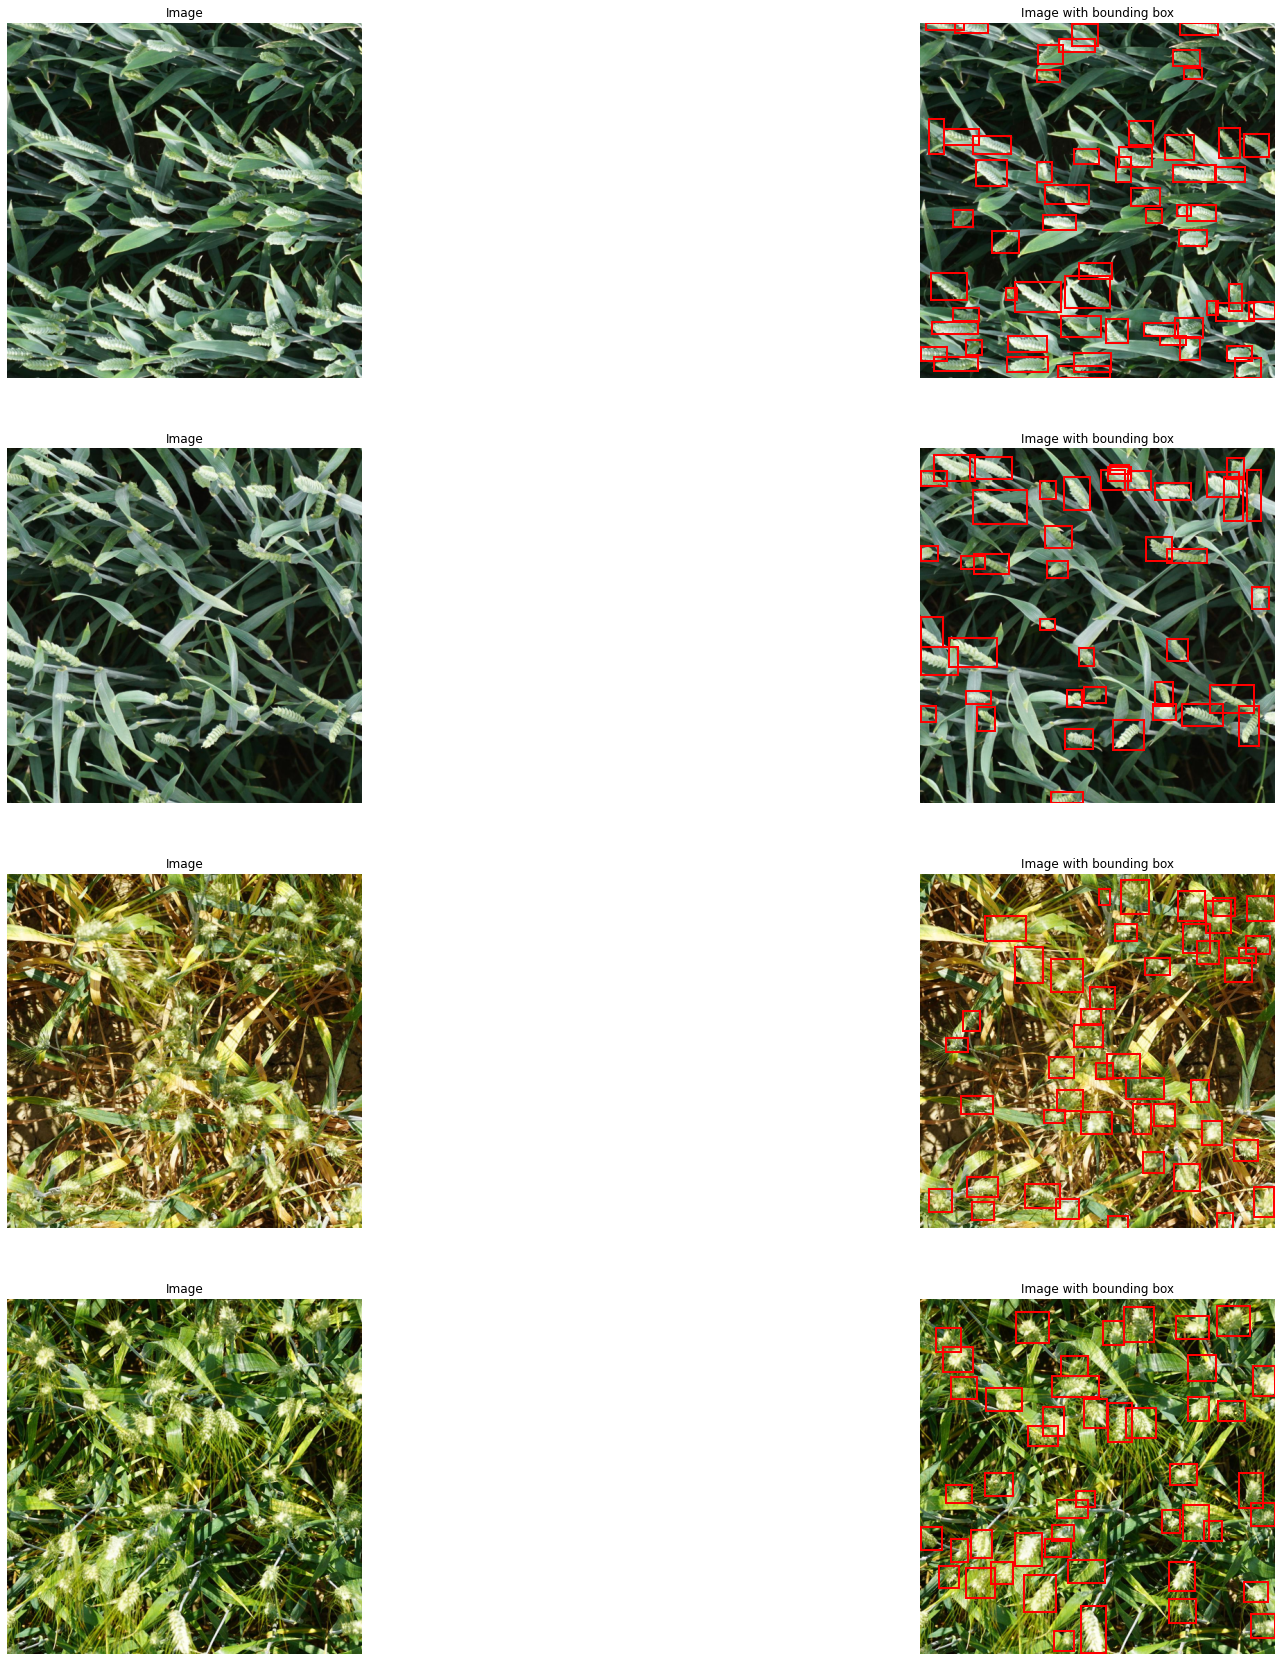

In [ ]:
def imshow(img_data, bbx_data, size):
    fig, ax = plt.subplots(nrows = size, ncols = 2, figsize=(30, 30))
    for i, (img, bbx) in enumerate(zip(img_data,bbx_data)):
        img = img / 2 + 0.5
        npimg = img.numpy()
        npimg = np.transpose(npimg,(1, 2, 0))
        ax[i, 0].set_title("Image")
        ax[i, 0].set_axis_off()
        ax[i, 0].imshow(npimg)
        bboxes = bbx['boxes'].numpy()
        for box in bboxes:
            ax[i,1].add_patch(
                patches.Rectangle(
                (box[0], box[1]),
                box[2]-box[0],
                box[3]-box[1],
                linewidth=2,
                fill=False,
                color='red'))
        ax[i, 1].set_axis_off()
        ax[i, 1].set_title("Image with bounding box")
        ax[i, 1].imshow(npimg)

dataiter = iter(trainloader)
data = dataiter.next()
images, bbx = data
imshow(images, bbx, len(images))
plt.show()
plt.close()